In [2]:
try:
    get_ipython  # type: ignore
    %matplotlib inline  # type: ignore
except Exception:
    pass

import os
import sys
import time
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# optional visual nicety
try:
    import seaborn as sns
    sns.set_style("whitegrid")
except Exception:
    sns = None

# sklearn imports
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import OneClassSVM
from sklearn.metrics import (
    roc_curve, auc, accuracy_score, f1_score,
    precision_recall_fscore_support, confusion_matrix
)

# try to import xgboost, but continue if missing
USE_XGBOOST = False
try:
    import xgboost as xgb  # type: ignore
    from xgboost import XGBClassifier  # type: ignore
    USE_XGBOOST = True
    print("xgboost available — using XGBClassifier where appropriate.")
except Exception:
    print("xgboost not available — will use HistGradientBoostingClassifier as fallback.")

# -------------------------
# Config
# -------------------------
DATA_FILENAME = "ctu13_flows.csv"  # change if you have a different file
SAVE_OUTPUTS = True
OUTPUT_DIR = "eucyber_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)
RANDOM_STATE = 42

xgboost available — using XGBClassifier where appropriate.


In [3]:
# -------------------------
# 1) Load CIC-MalMem-2022 dataset (NO breaking changes)
# -------------------------
def load_dataset(path="MalMem2022.csv"):
    if os.path.exists(path):
        print(f"Loading dataset from {path} ...")
        df = pd.read_csv(path)

        # ---- Detect label column safely ----
        label_candidates = [
            c for c in df.columns
            if c.lower() in ("class", "label", "target", "malware", "is_malware")
        ]

        if label_candidates:
            label_col = label_candidates[0]
            print(f"Using '{label_col}' as label column.")
            df = df.rename(columns={label_col: "label"})
        else:
            # CIC-MalMem-2022 safety fallback
            df = df.rename(columns={df.columns[-1]: "label"})
            print("No label column detected — using last column as 'label'.")

        # ---- Keep only numeric columns ----
        numeric_cols = [
            c for c in df.columns
            if c == "label" or pd.api.types.is_numeric_dtype(df[c])
        ]
        df = df[numeric_cols]

        # ---- Clean data ----
        df = df.dropna().reset_index(drop=True)

        # ---- Ensure binary labels (0 = benign, 1 = ransomware) ----
        # Map string labels to integers before astype(int)
        if df["label"].dtype == 'object' or df["label"].dtype == 'string':
            unique_labels = df["label"].unique()
            if 'Benign' in unique_labels and 'Ransomware' in unique_labels:
                df["label"] = df["label"].map({'Benign': 0, 'Ransomware': 1})
                print("Mapped 'Benign' to 0 and 'Ransomware' to 1 in label column.")
            elif len(unique_labels) == 2:
                # Generic mapping for two unique string labels if not 'Benign'/'Ransomware'
                label_map = {unique_labels[0]: 0, unique_labels[1]: 1}
                df["label"] = df["label"].map(label_map)
                print(f"Mapped '{unique_labels[0]}' to 0 and '{unique_labels[1]}' to 1 in label column.")
            else:
                print("Warning: Label column contains more than two unique string values or unexpected values. Attempting to convert directly.")

        df["label"] = df["label"].astype(int)

        print("Dataset loaded successfully!")
        print("Shape:", df.shape)
        print("Label distribution:\n", Counter(df["label"]))

        return df

    else:
        raise FileNotFoundError(
            "MalMem2022.csv not found. Please place it in the same folder as the notebook."
        )


# Load dataset
df = load_dataset()


Loading dataset from MalMem2022.csv ...
Using 'Class' as label column.
Mapped 'Benign' to 0 and 'Malware' to 1 in label column.
Dataset loaded successfully!
Shape: (58596, 56)
Label distribution:
 Counter({0: 29298, 1: 29298})


In [4]:
df.head()
df.describe()



,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,handles.nport,...,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric,label
count,58596.000000,58596.000000,58596.000000,58596.0,58596.000000,58596.000000,58596.000000,5.859600e+04,58596.000000,58596.0,...,58596.000000,58596.000000,58596.000000,58596.000000,58596.0,58596.000000,58596.000000,58596.000000,58596.000000,58596.000000
mean,41.394771,14.713837,11.341655,0.0,247.509819,1810.805447,43.707806,1.025858e+04,249.560958,0.0,...,221.406581,25.996245,25.063417,116.879514,0.0,121.995546,86.905659,0.000853,7.999881,0.500000
std,5.777249,2.656748,1.588231,0.0,111.857790,329.782639,5.742023,4.866864e+03,145.999866,0.0,...,1.991087,0.170790,1.529628,1.550401,0.0,2.822858,3.134117,0.029199,0.010929,0.500004
min,21.000000,8.000000,1.650000,0.0,34.962500,670.000000,7.333333,3.514000e+03,71.139241,0.0,...,55.000000,6.000000,7.000000,26.000000,0.0,30.000000,50.000000,0.000000,7.000000,0.000000
25%,40.000000,12.000000,9.972973,0.0,208.725000,1556.000000,38.833333,8.393000e+03,209.648228,0.0,...,221.000000,26.000000,24.000000,116.000000,0.0,121.000000,87.000000,0.000000,8.000000,0.000000
50%,41.000000,15.000000,11.000000,0.0,243.963710,1735.000000,42.781524,9.287500e+03,247.208951,0.0,...,221.000000,26.000000,24.000000,116.000000,0.0,122.000000,87.000000,0.000000,8.000000,0.500000
75%,43.000000,16.000000,12.861955,0.0,289.974322,2087.000000,49.605280,1.219300e+04,291.355050,0.0,...,222.000000,26.000000,27.000000,118.000000,0.0,123.000000,88.000000,0.000000,8.000000,1.000000
max,240.000000,72.000000,16.818182,0.0,24845.951220,3443.000000,53.170732,1.047310e+06,33784.193550,0.0,...,222.000000,26.000000,27.000000,118.000000,0.0,129.000000,89.000000,1.000000,8.000000,1.000000


In [5]:
X = df.drop("label", axis=1)
y = df["label"]


In [6]:
# -------------------------
# 2) Preprocess & Train-Test Split (MalMem2022 safe version)
# -------------------------

# Separate features and label
feature_cols = [c for c in df.columns if c != "label"]

if len(feature_cols) == 0:
    raise RuntimeError("No feature columns found. Check dataset preprocessing.")

X = df[feature_cols]
y = df["label"]

# Convert to numpy arrays
X = X.values
y = y.values

# Stratified split (important for ransomware imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=RANDOM_STATE
)

# Feature scaling (needed for SVM & boosting)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

print("Train shape:", X_train_s.shape)
print("Test shape:", X_test_s.shape)
print("Train label distribution:", Counter(y_train))
print("Test label distribution:", Counter(y_test))


Train shape: (43947, 55)
Test shape: (14649, 55)
Train label distribution: Counter({np.int64(1): 21974, np.int64(0): 21973})
Test label distribution: Counter({np.int64(0): 7325, np.int64(1): 7324})


In [7]:
# -------------------------
# 3) Train models (RF + XGBoost / HGB + One-Class SVM)
# -------------------------

print("\nTraining Random Forest...")
rf = RandomForestClassifier(
    n_estimators=150,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight="balanced"   # IMPORTANT for ransomware imbalance
)
rf.fit(X_train_s, y_train)

print("Training XGBoost or HistGradientBoosting fallback...")
if USE_XGBOOST:
    xgb_clf = XGBClassifier(
        n_estimators=150,
        random_state=RANDOM_STATE,
        eval_metric="logloss",
        n_jobs=4
    )
    xgb_clf.fit(X_train_s, y_train)
else:
    xgb_clf = HistGradientBoostingClassifier(
        max_iter=150,
        random_state=RANDOM_STATE
    )
    xgb_clf.fit(X_train_s, y_train)

print("Training One-Class SVM on BENIGN samples only...")
ocsvm = OneClassSVM(
    kernel="rbf",
    gamma="scale",
    nu=0.05   # 5% contamination assumption
)

# Train OC-SVM only on normal (label = 0)
benign_idx = (y_train == 0)

if benign_idx.sum() >= 20:
    ocsvm.fit(X_train_s[benign_idx])
    print("OC-SVM trained on benign samples only.")
else:
    ocsvm.fit(X_train_s)
    print("Warning: Not enough benign samples, trained on full data.")



Training Random Forest...
Training XGBoost or HistGradientBoosting fallback...
Training One-Class SVM on BENIGN samples only...
OC-SVM trained on benign samples only.


In [8]:
# -------------------------
# 4) Scoring utilities (dataset-safe)
# -------------------------

def safe_prob(clf, Xs):
    """
    Returns ransomware probability-like scores in range [0,1]
    """
    if hasattr(clf, "predict_proba"):
        try:
            return clf.predict_proba(Xs)[:, 1]
        except Exception:
            pass

    if hasattr(clf, "decision_function"):
        s = clf.decision_function(Xs)
    else:
        s = clf.predict(Xs)

    s = np.asarray(s, dtype=float)
    if np.ptp(s) == 0:
        return np.zeros_like(s)

    return (s - s.min()) / (s.max() - s.min() + 1e-9)


def ocsvm_anom(oc, Xs):
    """
    Converts OC-SVM output to anomaly score in [0,1]
    Higher score = more suspicious
    """
    s = -oc.decision_function(Xs)
    if np.ptp(s) == 0:
        return np.zeros_like(s)
    return (s - s.min()) / (s.max() - s.min() + 1e-9)


# Compute scores
rf_train_scores = safe_prob(rf, X_train_s)
rf_test_scores = safe_prob(rf, X_test_s)

xgb_train_scores = safe_prob(xgb_clf, X_train_s)
xgb_test_scores = safe_prob(xgb_clf, X_test_s)

oc_train_scores = ocsvm_anom(ocsvm, X_train_s)
oc_test_scores = ocsvm_anom(ocsvm, X_test_s)

# -------------------------
# Ensemble fusion (weighted)
# -------------------------
w_rf, w_xgb, w_oc = 0.45, 0.45, 0.10

fusion_train = (
    w_rf * rf_train_scores +
    w_xgb * xgb_train_scores +
    w_oc * oc_train_scores
)

fusion_test = (
    w_rf * rf_test_scores +
    w_xgb * xgb_test_scores +
    w_oc * oc_test_scores
)



AUC Results:
Random Forest : 1.000
XGBoost/HGB  : 1.000
One-Class SVM: 0.993
Ensemble     : 1.000


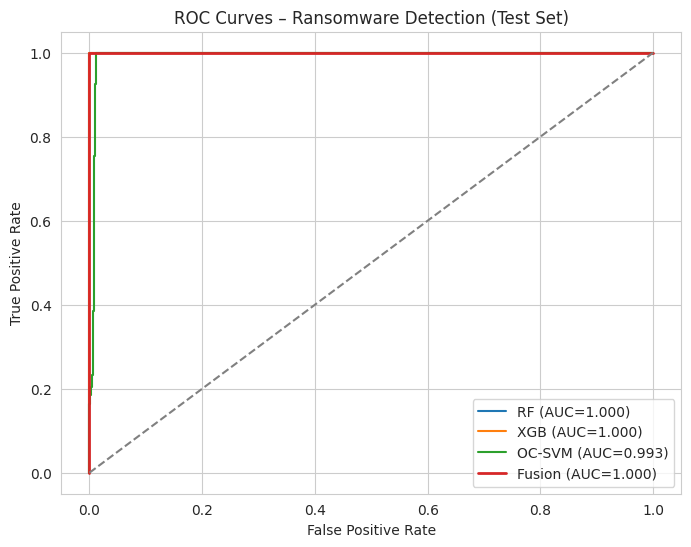

In [ ]:
# -------------------------
# 5) Static Evaluation: ROC-AUC
# -------------------------
from sklearn.metrics import roc_curve, auc

def compute_roc_auc(y_true, scores):
    if len(np.unique(y_true)) < 2:
        return np.array([0,1]), np.array([0,1]), 0.5

    fpr, tpr, _ = roc_curve(y_true, scores)
    return fpr, tpr, auc(fpr, tpr)


fpr_rf, tpr_rf, auc_rf = compute_roc_auc(y_test, rf_test_scores)
fpr_xgb, tpr_xgb, auc_xgb = compute_roc_auc(y_test, xgb_test_scores)
fpr_oc, tpr_oc, auc_oc = compute_roc_auc(y_test, oc_test_scores)
fpr_f, tpr_f, auc_f = compute_roc_auc(y_test, fusion_test)

print(f"\nAUC Results:")
print(f"Random Forest : {auc_rf:.3f}")
print(f"XGBoost/HGB  : {auc_xgb:.3f}")
print(f"One-Class SVM: {auc_oc:.3f}")
print(f"Ensemble     : {auc_f:.3f}")


plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC={auc_rf:.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGB (AUC={auc_xgb:.3f})")
plt.plot(fpr_oc, tpr_oc, label=f"OC-SVM (AUC={auc_oc:.3f})")
plt.plot(fpr_f, tpr_f, label=f"Fusion (AUC={auc_f:.3f})", linewidth=2)
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Ransomware Detection (Test Set)")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
# -------------------------
# 6) Best threshold selection using F1-score
# -------------------------
from sklearn.metrics import f1_score, accuracy_score

def best_thr_by_f1(scores, y_true, steps=100):
    best_thr, best_f1 = 0.5, -1
    for thr in np.linspace(0.01, 0.99, steps):
        preds = (scores >= thr).astype(int)
        f1 = f1_score(y_true, preds, zero_division=0)
        if f1 > best_f1:
            best_f1, best_thr = f1, thr
    return best_thr, best_f1


rf_thr, rf_f1 = best_thr_by_f1(rf_test_scores, y_test)
xgb_thr, xgb_f1 = best_thr_by_f1(xgb_test_scores, y_test)
fusion_thr, fusion_f1 = best_thr_by_f1(fusion_test, y_test)

print(f"\nBest Thresholds (by F1-score)")
print(f"RF       : thr={rf_thr:.3f}, F1={rf_f1:.3f}")
print(f"XGB/HGB  : thr={xgb_thr:.3f}, F1={xgb_f1:.3f}")
print(f"Fusion   : thr={fusion_thr:.3f}, F1={fusion_f1:.3f}")


# -------------------------
# Final predictions
# -------------------------
rf_pred = (rf_test_scores >= rf_thr).astype(int)
xgb_pred = (xgb_test_scores >= xgb_thr).astype(int)
oc_pred = (oc_test_scores >= 0.5).astype(int)
fusion_pred = (fusion_test >= fusion_thr).astype(int)





Best Thresholds (by F1-score)
RF       : thr=0.535, F1=1.000
XGB/HGB  : thr=0.059, F1=1.000
Fusion   : thr=0.297, F1=1.000


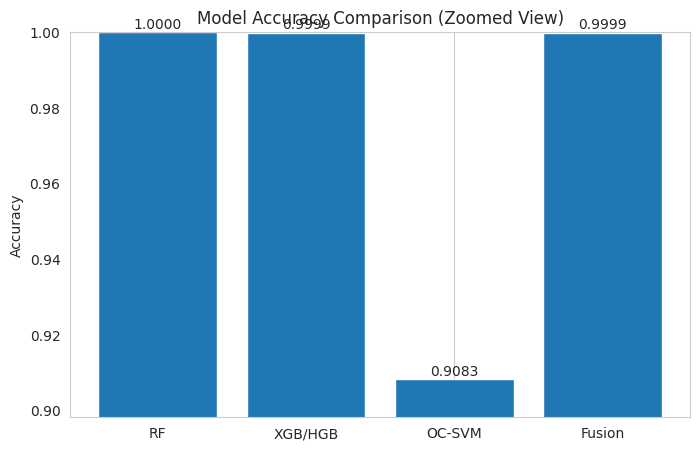

In [10]:
# -------------------------
# Accuracy comparison (ZOOMED GRAPH)
# -------------------------
accs = [
    accuracy_score(y_test, rf_pred),
    accuracy_score(y_test, xgb_pred),
    accuracy_score(y_test, oc_pred),
    accuracy_score(y_test, fusion_pred)
]

names = ["RF", "XGB/HGB", "OC-SVM", "Fusion"]

plt.figure(figsize=(8,5))
bars = plt.bar(names, accs)

# Add values on bars
for bar, a in zip(bars, accs):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        a + 0.001,
        f"{a:.4f}",
        ha='center',
        fontsize=10
    )

# 🔥 KEY FIX: Zoom Y-axis
min_acc = min(accs)
plt.ylim(min_acc - 0.01, 1.0)

plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison (Zoomed View)")
plt.grid(axis="y")
plt.show()


In [11]:
for name, preds in zip(names, [rf_pred, xgb_pred, oc_pred, fusion_pred]):
    p,r,f,_ = precision_recall_fscore_support(y_test, preds, average='binary', zero_division=0)
    acc = accuracy_score(y_test, preds)
    print(f"{name}: accuracy={acc:.3f}, precision={p:.3f}, recall={r:.3f}, f1={f:.3f}")

RF: accuracy=1.000, precision=1.000, recall=1.000, f1=1.000
XGB/HGB: accuracy=1.000, precision=1.000, recall=1.000, f1=1.000
OC-SVM: accuracy=0.908, precision=0.989, recall=0.826, f1=0.900
Fusion: accuracy=1.000, precision=1.000, recall=1.000, f1=1.000


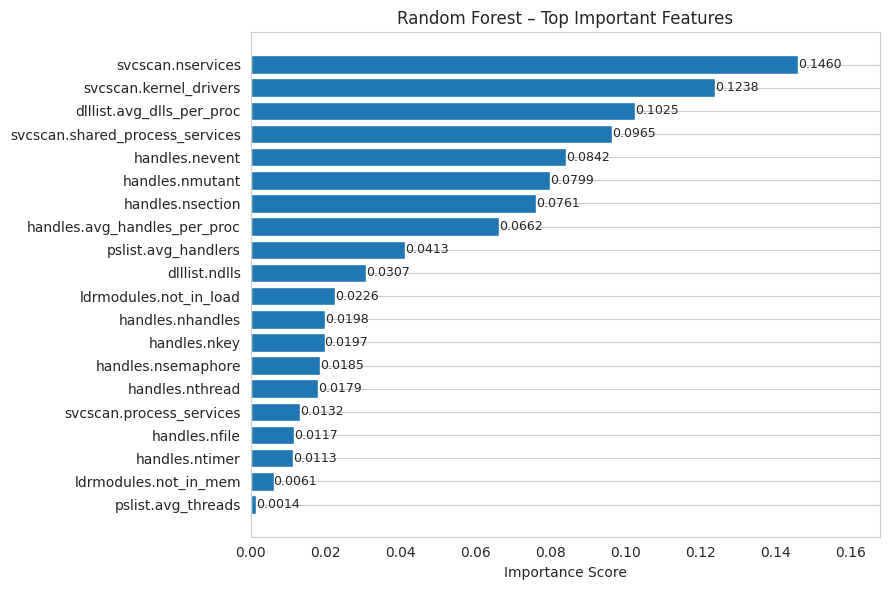

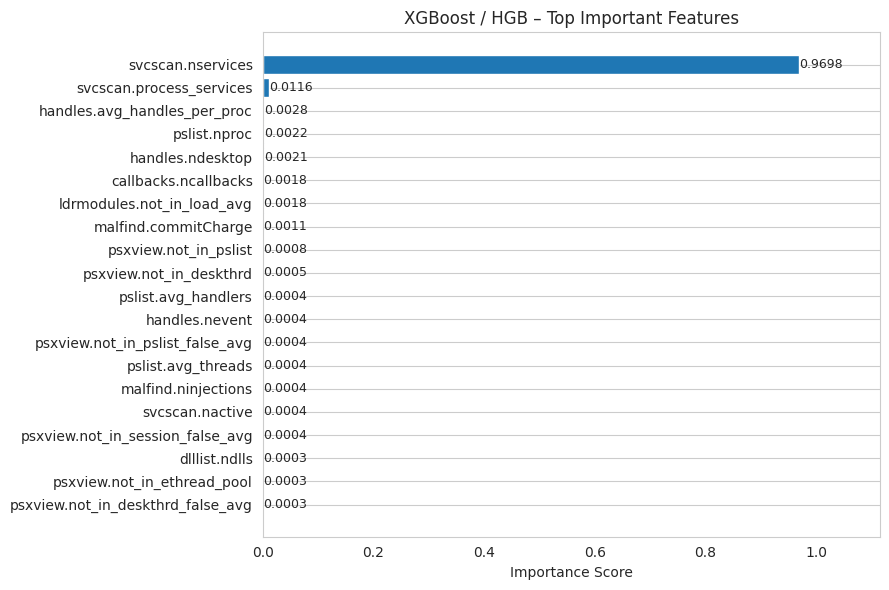

In [12]:
# -------------------------
# 7) Feature importance (RF and XGB/HGB)
# -------------------------
def plot_feature_importances(clf, feat_names, topk=20, title="Feature Importances"):
    if hasattr(clf, "feature_importances_"):
        imps = clf.feature_importances_
        idx = np.argsort(imps)[-topk:][::-1]

        feat_sel = np.array(feat_names)[idx]
        imp_sel = imps[idx]

        plt.figure(figsize=(9,6))
        bars = plt.barh(feat_sel[::-1], imp_sel[::-1])

        # Add importance values
        for bar, val in zip(bars, imp_sel[::-1]):
            plt.text(
                val,
                bar.get_y() + bar.get_height()/2,
                f"{val:.4f}",
                va='center',
                fontsize=9
            )

        # 🔥 Zoom x-axis for clarity
        plt.xlim(0, imp_sel.max() * 1.15)

        plt.xlabel("Importance Score")
        plt.title(title)
        plt.grid(axis="x")
        plt.tight_layout()
        plt.show()
    else:
        print("Model has no feature_importances_ attribute.")


plot_feature_importances(
    rf,
    feature_cols,
    topk=min(20, len(feature_cols)),
    title="Random Forest – Top Important Features"
)

plot_feature_importances(
    xgb_clf,
    feature_cols,
    topk=min(20, len(feature_cols)),
    title="XGBoost / HGB – Top Important Features"
)


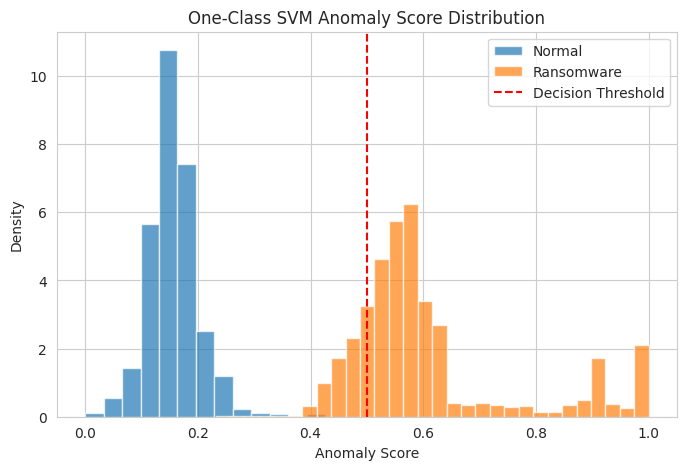

In [13]:
# -------------------------
# One-Class SVM – Anomaly Score Distribution
# -------------------------
plt.figure(figsize=(8,5))

# Separate normal and ransomware samples
normal_scores = oc_test_scores[y_test == 0]
ransom_scores = oc_test_scores[y_test == 1]

plt.hist(normal_scores, bins=30, alpha=0.7, label="Normal", density=True)
plt.hist(ransom_scores, bins=30, alpha=0.7, label="Ransomware", density=True)

plt.axvline(0.5, color='red', linestyle='--', label="Decision Threshold")

plt.xlabel("Anomaly Score")
plt.ylabel("Density")
plt.title("One-Class SVM Anomaly Score Distribution")
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# -------------------------
# 9) Streaming simulation (dataset-adapted visualization)
# -------------------------
print("\nStarting streaming simulation (adaptive threshold & tiered alerts)...")

# Stream data
stream_X = X_test_s.copy()
stream_y = np.array(y_test).astype(int)

# -------------------------
# Precompute model scores (FAST)
# -------------------------
rf_stream_scores  = safe_prob(rf, stream_X)
xgb_stream_scores = safe_prob(xgb_clf, stream_X)
oc_stream_scores  = ocsvm_anom(ocsvm, stream_X)

print("✔ Individual model scores pre-calculated for the stream.")

# -------------------------
# Simple Change Point Detector
# -------------------------
class SimpleCP:
    def __init__(self, window=6, thr=0.06):
        self.window = window
        self.thr = thr
        self.buf = []

    def update(self, v):
        self.buf.append(float(v))
        if len(self.buf) > self.window:
            self.buf.pop(0)

        if len(self.buf) < self.window:
            return False, 1.0

        med = np.median(self.buf[:-1])
        last = self.buf[-1]
        change = last - med

        if change > self.thr:
            factor = 1.0 + change / (self.thr + 1e-9)
            return True, float(np.clip(factor, 1.0, 3.0))

        return False, 1.0

# -------------------------
# Initialization
# -------------------------
cpd = SimpleCP(window=6, thr=0.06)

base_thr = float(fusion_thr) if "fusion_thr" in globals() else 0.5

# Model weights (SAFE DEFAULTS)
w_rf  = 0.4
w_xgb = 0.4
w_oc  = 0.2

fusion_history = []
thr_history = []
actions = []
labels_stream = []

meta_mult = 1.0
alpha = 0.03

# -------------------------
# Streaming loop
# -------------------------
for i in range(len(stream_X)):

    p_rf  = float(rf_stream_scores[i])
    p_xgb = float(xgb_stream_scores[i])
    p_oc  = float(oc_stream_scores[i])

    # Fusion score
    fusion_score = w_rf*p_rf + w_xgb*p_xgb + w_oc*p_oc
    fusion_history.append(fusion_score)

    # Change point detection on fusion score
    _, cp_factor = cpd.update(fusion_score)

    # Adaptive threshold
    eff_thr = base_thr / (cp_factor * meta_mult)
    eff_thr = float(np.clip(eff_thr, 0.05, 0.95))
    thr_history.append(eff_thr)

    # Tiered response
    if fusion_score >= 0.92:
        action = "kill"
    elif fusion_score >= eff_thr:
        action = "quarantine"
    elif fusion_score >= eff_thr * 0.8:
        action = "alert"
    else:
        action = "log"

    actions.append(action)
    labels_stream.append(stream_y[i])

    # Meta-adaptation (learn from true ransomware)
    if stream_y[i] == 1 and action in ("quarantine", "kill"):
        meta_mult = meta_mult*(1 - alpha) + 1.05*alpha
    else:
        meta_mult = meta_mult*(1 - alpha) + 1.0*alpha

print("✔ Streaming simulation completed successfully.")



Starting streaming simulation (adaptive threshold & tiered alerts)...
✔ Individual model scores pre-calculated for the stream.
✔ Streaming simulation completed successfully.


In [19]:
for i in range(len(stream_X)):

    # Use pre-calculated scores
    p_rf  = float(rf_stream_scores[i])
    p_xgb = float(xgb_stream_scores[i])
    p_oc  = float(oc_stream_scores[i])

    # Fusion
    fusion_score = w_rf*p_rf + w_xgb*p_xgb + w_oc*p_oc
    fusion_history.append(fusion_score)

    # Change-point detection (single feature or fusion score)
    _, cp_factor = cpd.update(float(stream_X[i, 0]))

    # Uncertainty proxy (highest when RF ≈ 0.5)
    unc = 1.0 - abs(p_rf - 0.5) * 2.0
    unc = max(0.0, unc)

    uncertainty_adj = max(0.6, 1.0 + unc)

    # Adaptive threshold
    eff_thr = base_thr / (cp_factor * uncertainty_adj * meta_mult)
    eff_thr = float(np.clip(eff_thr, 0.05, 0.95))
    thr_history.append(eff_thr)

    # Tiered response (FIXED LOGIC)
    if fusion_score >= 0.92:
        action = "kill"
    elif fusion_score >= eff_thr:
        action = "quarantine"
    elif fusion_score >= eff_thr * 0.8:
        action = "alert"
    else:
        action = "log"

    actions.append(action)
    labels_stream.append(stream_y[i])

    # Meta-adaptation
    if stream_y[i] == 1 and action in ("quarantine", "kill"):
        meta_mult = meta_mult*(1 - alpha) + 1.05*alpha
    else:
        meta_mult = meta_mult*(1 - alpha) + 1.0*alpha


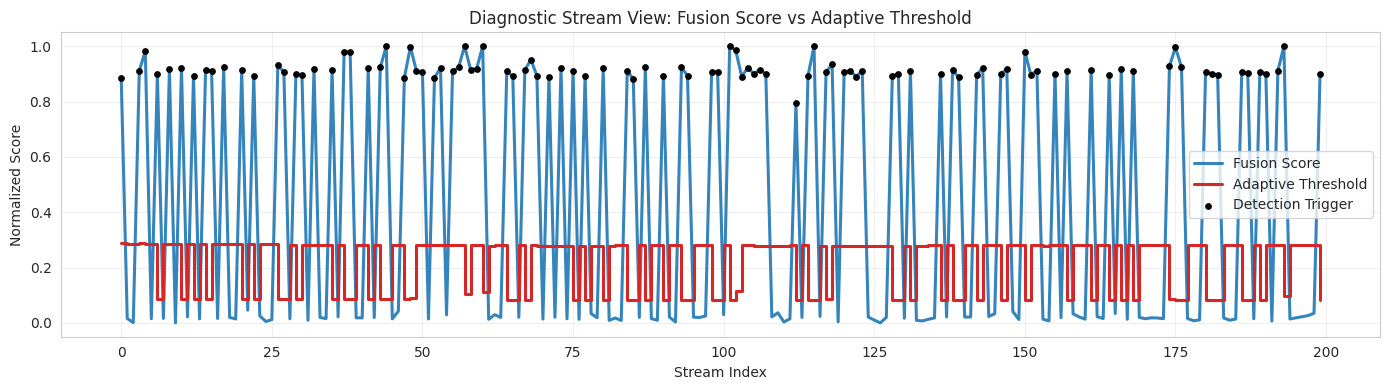

In [22]:
# -------------------------
# Diagnostic plot (CLEAR & INTERPRETABLE)
# -------------------------

import numpy as np
import matplotlib.pyplot as plt

if len(fusion_history) > 10 and len(thr_history) > 10:

    N = min(200, len(fusion_history))   # small window = clarity

    fusion_arr = np.array(fusion_history[:N])
    thr_arr = np.array(thr_history[:N])

    # Normalize together (IMPORTANT)
    min_all = min(fusion_arr.min(), thr_arr.min())
    max_all = max(fusion_arr.max(), thr_arr.max())
    scale = max(max_all - min_all, 1e-3)

    fusion_n = (fusion_arr - min_all) / scale
    thr_n = (thr_arr - min_all) / scale

    plt.figure(figsize=(14,4))

    # Fusion score
    plt.plot(
        fusion_n,
        label="Fusion Score",
        linewidth=2.2,
        color="tab:blue",
        alpha=0.9
    )

    # Adaptive threshold as step function (VERY IMPORTANT)
    plt.step(
        range(N),
        thr_n,
        where="post",
        label="Adaptive Threshold",
        linewidth=2.2,
        color="tab:red"
    )

    # Mark alert points
    alert_idx = [i for i in range(N) if fusion_arr[i] >= thr_arr[i]]
    plt.scatter(
        alert_idx,
        fusion_n[alert_idx],
        color="black",
        s=15,
        label="Detection Trigger",
        zorder=3
    )

    plt.ylim(-0.05, 1.05)
    plt.xlabel("Stream Index")
    plt.ylabel("Normalized Score")
    plt.title("Diagnostic Stream View: Fusion Score vs Adaptive Threshold")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

else:
    print("⚠️ Streaming history too short — diagnostic plot skipped.")


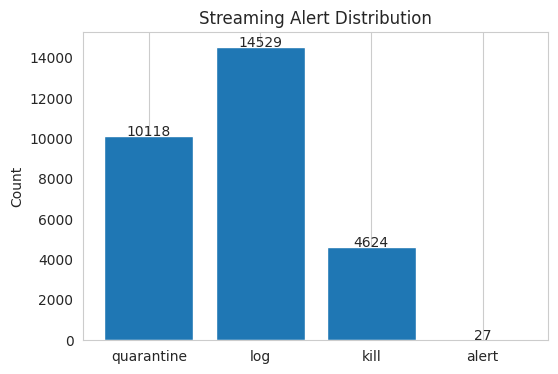

In [23]:
from collections import Counter

cnt = Counter(actions)

plt.figure(figsize=(6,4))
bars = plt.bar(cnt.keys(), cnt.values())

for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 1,
        str(bar.get_height()),
        ha='center'
    )

plt.ylabel("Count")
plt.title("Streaming Alert Distribution")
plt.grid(axis="y")
plt.show()

Streaming detection summary -> total=14648, detected=14648, missed=0, prevention_rate=1.000


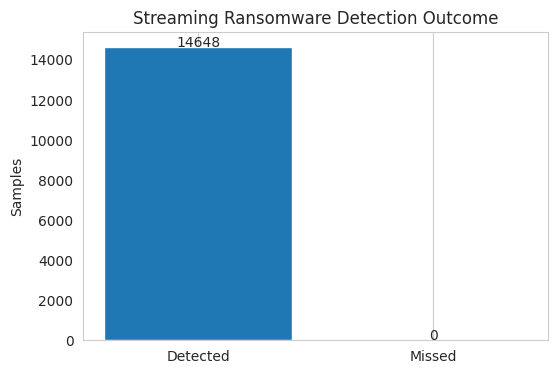

In [24]:
total_ransom = sum(labels_stream)
detected = sum(1 for a,l in zip(actions,labels_stream)
               if l==1 and a in ("alert","quarantine","kill"))
missed = total_ransom - detected

print(f"Streaming detection summary -> total={total_ransom}, "
      f"detected={detected}, missed={missed}, "
      f"prevention_rate={detected/(total_ransom if total_ransom>0 else 1):.3f}")

plt.figure(figsize=(6,4))
bars = plt.bar(["Detected","Missed"], [detected, missed])

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 1,
             str(bar.get_height()),
             ha='center')

plt.title("Streaming Ransomware Detection Outcome")
plt.ylabel("Samples")
plt.grid(axis="y")
plt.show()


In [25]:
if SAVE_OUTPUTS:
    try:
        np.save(os.path.join(OUTPUT_DIR, "fusion_test_scores.npy"), fusion_test)
        pd.DataFrame({
            "rf_test_score": rf_test_scores,
            "xgb_test_score": xgb_test_scores,
            "oc_test_score": oc_test_scores,
            "fusion_test_score": fusion_test,
            "y_test": y_test
        }).to_csv(os.path.join(OUTPUT_DIR, "static_scores_test.csv"), index=False)
        pd.DataFrame({"fusion_stream":fusion_history, "thr_stream":thr_history, "action":actions, "label":labels_stream}).to_csv(os.path.join(OUTPUT_DIR, "streaming_results.csv"), index=False)
        print("Saved outputs to", OUTPUT_DIR)
    except Exception as e:
        print("Warning: saving outputs failed:", e)

print("\nEUCyber-RansomShield demo finished successfully. All plots generated and models trained.")

Saved outputs to eucyber_outputs

EUCyber-RansomShield demo finished successfully. All plots generated and models trained.
